In [49]:
import numpy as np
import osr_methods as osr
import ocr_methods as ocr
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [50]:
#exterior
x = np.array([14., 6.])
#x = np.array([0., -2.5])

#interior
#x = np.array([30., 20.])

### Escolha dos métodos de OSR e OCR

In [51]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 1

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 6

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [52]:
# numero maximo de iteracoes na OSR
maxiter = 1000

# tolerancia para convergencia do gradiente na OSR
#tol_conv = 1E-6
tol_conv = 1E-7

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-8

# delta alpha do passo constante na OSR
line_step = 1E-2

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1.
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 10.
    beta = 0.1

#tolerancia OCR
#tol = 1E-5
tol = 1E-6

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [53]:
def f(x):
    return (x[0] - 10)**3 + (x[1] - 20)**3

def grad_f(x):
    a = 3*(x[0] - 10)**2
    b = 3*(x[1] - 20)**2
    return np.array([a, b])

def hess_f(x):
    #termo 1x1
    a = 6*(x[0] - 10)
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = 6*(x[1] - 20)
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

### Definição das restrições de desigualdade

In [54]:
def cl1(x):
    return 100 - (x[0] - 5)**2 - (x[1] - 5)**2

def grad_cl1(x):
    a = -2*(x[0] - 5)
    b = -2*(x[1] - 5)
    return np.array([a, b])

def hess_cl1(x):
    #termo 1x1
    a = -2.
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = -2.
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

def cl2(x):
    return -82.81 + (x[0] - 6)**2 + (x[1] - 5)**2

def grad_cl2(x):
    a = 2*(x[0] - 6)
    b = 2*(x[1] - 5)
    return np.array([a, b])

def hess_cl2(x):
    #termo 1x1
    a = 2.
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = 2.
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    
    return hess

def cl3(x):
    return 13 - x[0]

def grad_cl3(x):
    a = -1.
    b= 0.
    return np.array([a, b])

def hess_cl3(x):
    return np.zeros((2,2), dtype=float)

def cl4(x):
    return x[0] - 100

def grad_cl4(x):
    a = 1.
    b = 0.
    return np.array([a, b])

def hess_cl4(x):
    return np.zeros((2,2), dtype=float)

def cl5(x):
    return -x[1]

def grad_cl5(x):
    a = 0.
    b = -1.
    return np.array([a, b])

def hess_cl5(x):
    return np.zeros((2,2), dtype=float)

def cl6(x):
    return x[1] - 100

def grad_cl6(x):
    a = 0.
    b = 1.
    return np.array([a, b])

def hess_cl6(x):
    return np.zeros((2,2), dtype=float)

### Listas de Restrições e suas derivadas

In [55]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1, cl2, cl3, cl4, cl5, cl6]
grad_cl_list = [grad_cl1, grad_cl2, grad_cl3, grad_cl4, grad_cl5, grad_cl6]
hess_cl_list = [hess_cl1, hess_cl2, hess_cl3, hess_cl4, hess_cl5, hess_cl6]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

In [56]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listResultsOSR = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        # for i in np.arange(len(levellist)):
        #     levellist[i] = beta*levellist[i]
        if metodo_ocr == 1:
            params[-1] = []
            for cl in cl_list:
                if cl(x) > 0:
                    params[-1].append(1)
                else:
                    params[-1].append(0)
    listP_OSR, passos_OSR, conv_OSR, flag_conv_OSR, tempoExec_OSR = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listResultsOSR.append([listP_OSR, params, r, metodo_ocr, metodo_osr])
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r:.1e}, passos={passos_OSR}, conv_OCR={parc:.4e}, conv_OSR={conv_OSR:.4e}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]
        
        
        plt.close()
    

BFGS
1: x=[ 4.4960073  -8.78070431], r=1.0e+00, passos=1000, conv_OCR=4.0646e+03, conv_OSR=6.3887e-05
2: x=[ 6.12884702 -4.59225352], r=1.0e+01, passos=915, conv_OCR=7.6636e+02, conv_OSR=3.3575e-08
3: x=[10.84161941 -2.93893293], r=1.0e+02, passos=1000, conv_OCR=1.7396e+03, conv_OSR=9.9839e-05
4: x=[13.33663988 -0.45698233], r=1.0e+03, passos=1000, conv_OCR=7.3753e+02, conv_OSR=2.0867e-03
5: x=[13.77930068  0.24320312], r=1.0e+04, passos=1000, conv_OCR=1.2960e+03, conv_OSR=3.8344e-03
6: x=[14.08342027  0.81902446], r=1.0e+05, passos=1000, conv_OCR=1.3453e+01, conv_OSR=1.7026e-02
7: x=[14.09383721  0.84054953], r=1.0e+06, passos=1000, conv_OCR=1.3565e+00, conv_OSR=9.1638e-01
8: x=[14.09488367  0.84271948], r=1.0e+07, passos=1000, conv_OCR=1.3576e-01, conv_OSR=4.4536e-02
9: x=[14.09498837  0.84293665], r=1.0e+08, passos=1000, conv_OCR=1.3580e-02, conv_OSR=6.3487e+01
10: x=[14.09499884  0.84295837], r=1.0e+09, passos=1000, conv_OCR=1.3592e-03, conv_OSR=3.2525e+02
11: x=[14.09499988  0.842

### Plots de $\phi(x_1,x_2)$ e restrições

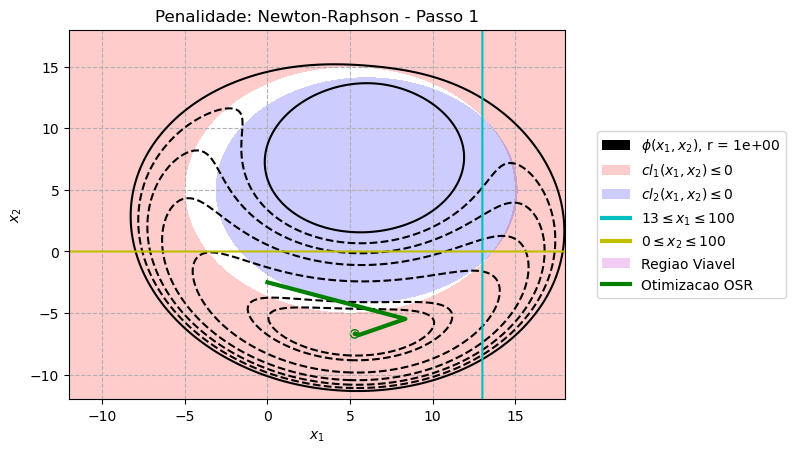

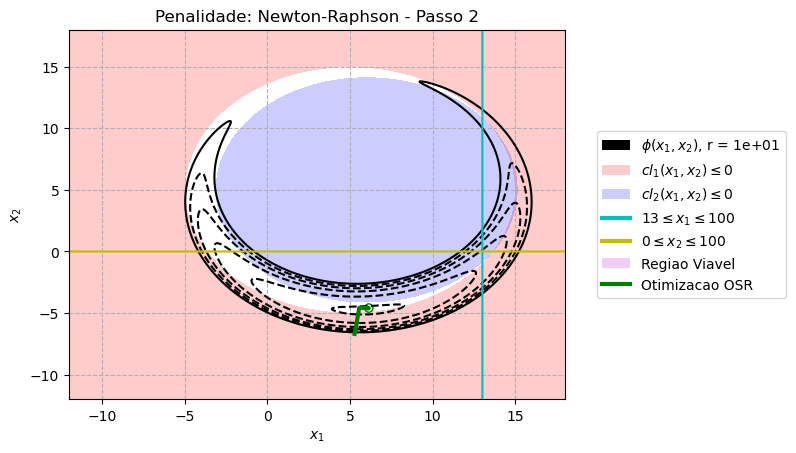

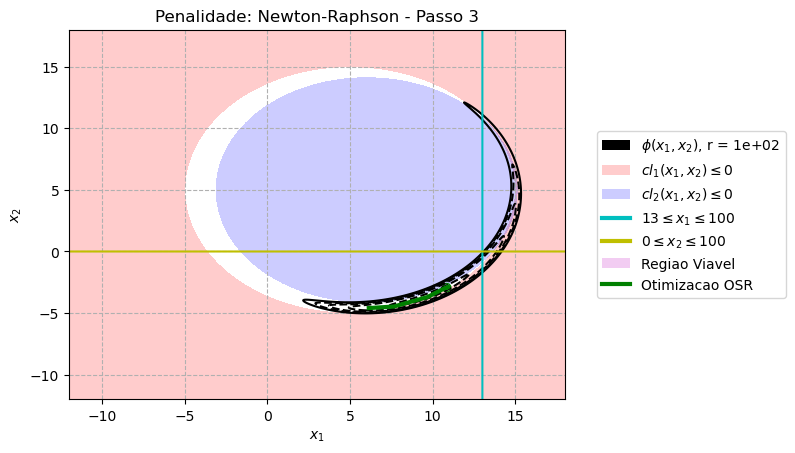

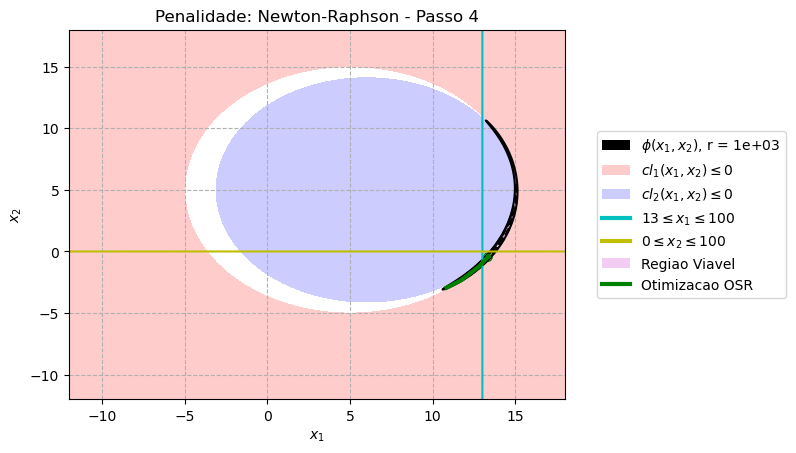

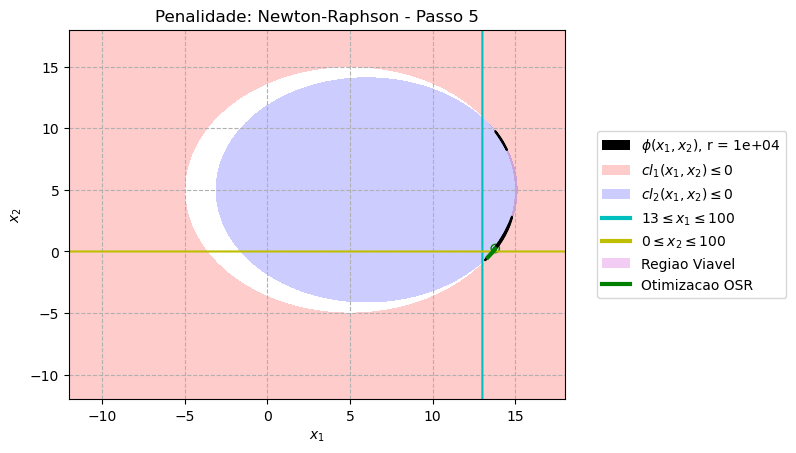

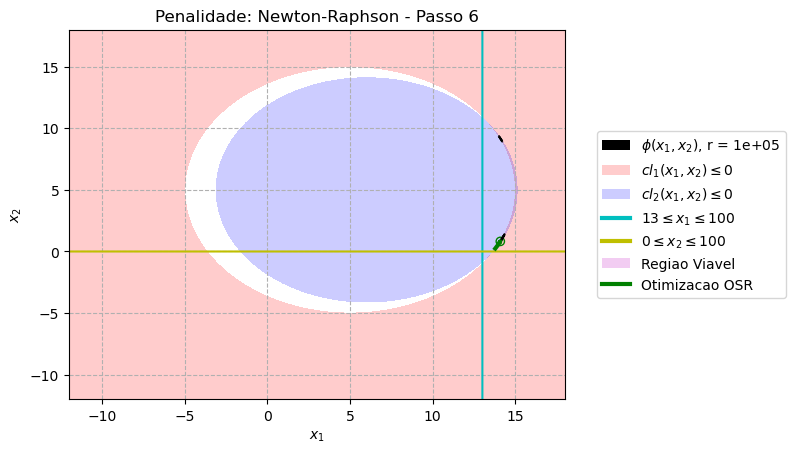

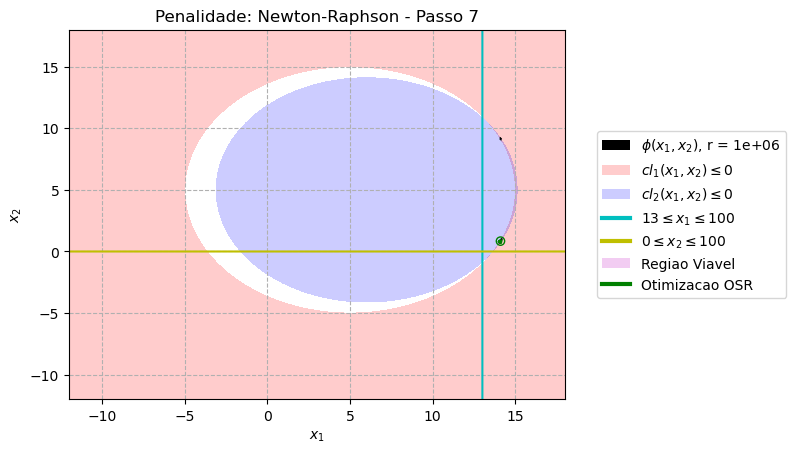

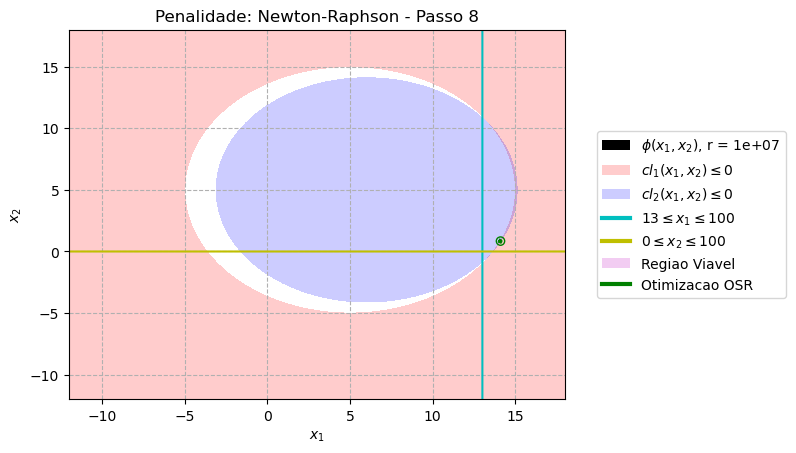

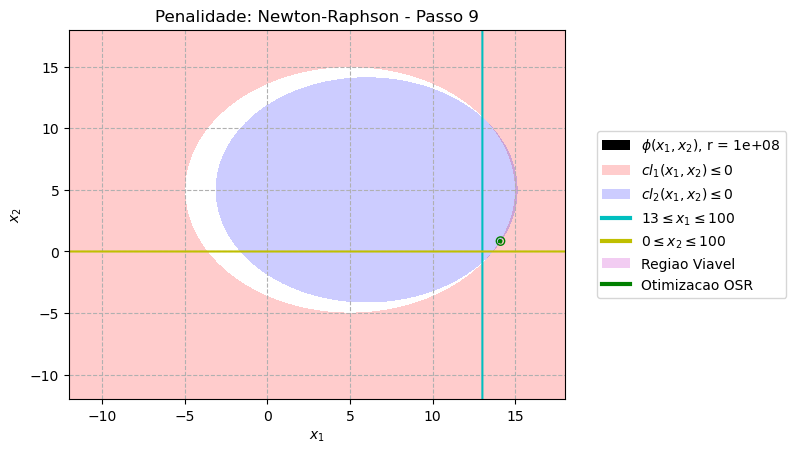

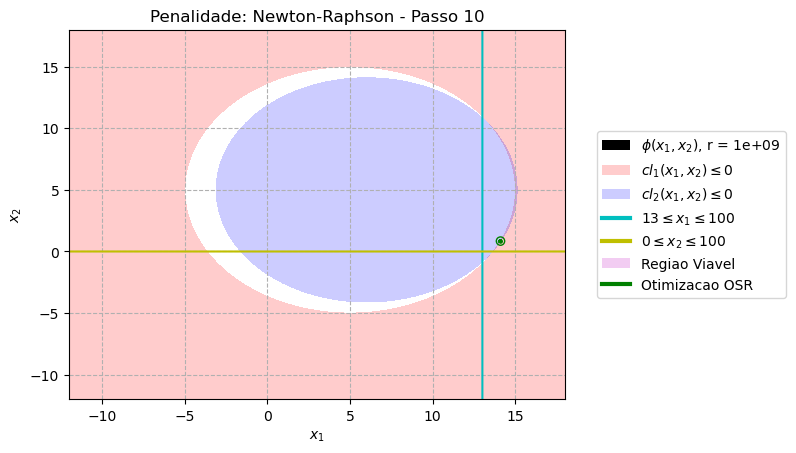

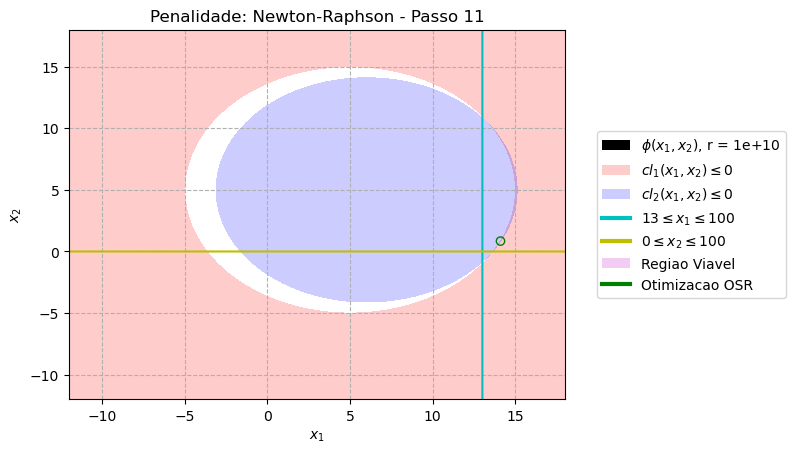

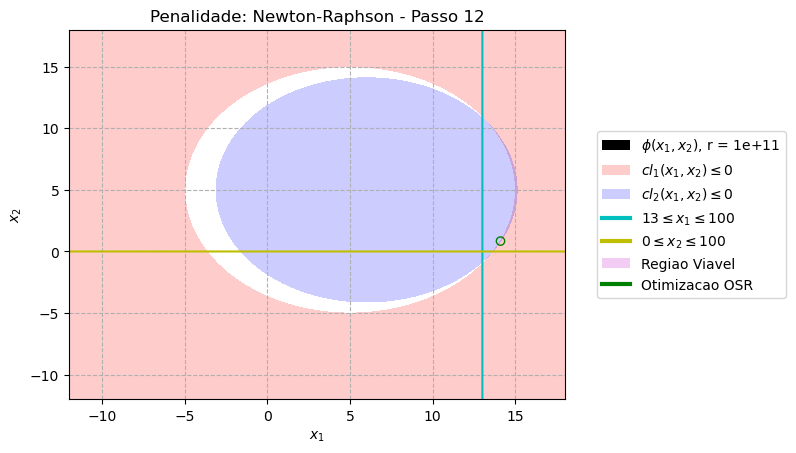

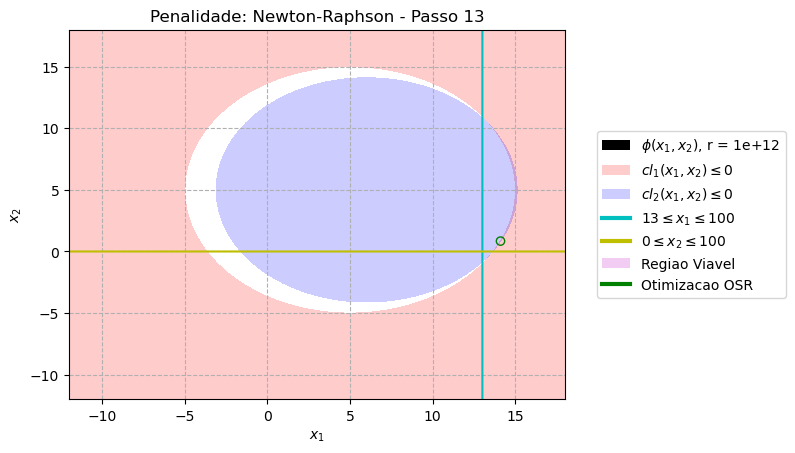

In [ ]:
x1 = np.linspace(-12,18, 3000)
x2 = np.linspace(-12,18, 3000)
X1, X2 = np.meshgrid(x1, x2)

levellist = [-15000,-13960, -10000, -6500, -4000, -2000,0]
#levellist = [-7000,-6970,-6950,-6930,-6910,-6900, -6600,-6515, -6508, -6505,-6500, -6498, -6495, -6490]
#multipliers = [1.048, 1.014, 1.0043, 1.0013, 1.00043, 1.00014, 1, 1, 1, 1, 1, 1, 1, 1]
k = 0
for item in listResultsOSR :
    
    fig, ax = plt.subplots()
    #print(ocr.phi_penal(item[0][-1], item[1], item[2]))
    if metodo_ocr == 1:
        X3 = ocr.phi_penal([X1,X2], item[1], item[2])
        
    elif metodo_ocr == 2:
        X3 = ocr.phi_bar([X1, X2], item[1], item[2])
       
    niveis = ax.contour(X1, X2, X3, levellist, colors='black')
    #ax.clabel(niveis, inline=1, fontsize=8)
      
    X3 = cl1([X1,X2])
    ax.contourf(X1, X2, X3, [-100000, 0], colors='red', alpha=0.2)

    X3 = cl2([X1,X2])
    ax.contourf(X1, X2, X3, [-10000000, 0], colors='blue', alpha=0.2)

    X3 = cl3([X1,X2])
    ax.contour(X1, X2, X3, [0], colors='c')

    X3 = cl5([X1,X2])
    ax.contour(X1, X2, X3, [0], colors='y')
          
    x = []
    y = []
    for P in item[0]:
        x.append(P[0])
        y.append(P[1])
    line3, = ax.plot(x, y, color='g', linewidth='3')
    ax.scatter(item[0][-1][0], item[0][-1][1], color='green',marker='o', facecolors='none')
    ax.set_xlabel('$x_1$', fontsize='10')
    ax.set_ylabel('$x_2$', fontsize='10')   
    
    proxy = [plt.Rectangle((0,0),1,1,fc = 'black'),plt.Rectangle((0,0),1,1,fc = 'r', alpha=0.2),plt.Rectangle((0,0),1,1,fc = 'b', alpha=0.2), plt.Line2D([0], [0], lw=3,  color='c'), plt.Line2D([0], [0], lw=3,  color='y'),  plt.Rectangle((0,0),1,1,fc = 'm', alpha=0.2), line3]    
    ax.legend(proxy, [f'$\phi(x_1,x_2)$, r = {item[2]:.0e}', '$cl_1(x_1,x_2) \leq 0$','$cl_2(x_1,x_2) \leq 0$', '$13 \leq x_1 \leq 100$', '$0 \leq x_2 \leq 100$', 'Regiao Viavel', 'Otimizacao OSR'], bbox_to_anchor=(1.05, 0.5), loc='center left')

       
    ax.grid(linestyle='--')
    titulo = n_met_ocr + ': ' + n_met + ' - ' + 'Passo ' + str(k+1)
    ax.set_title(titulo, fontsize=12)
    
    
    k = k+1
    
    

plt.show()

### Plot de $f(x_1, x_2)$ e restrições

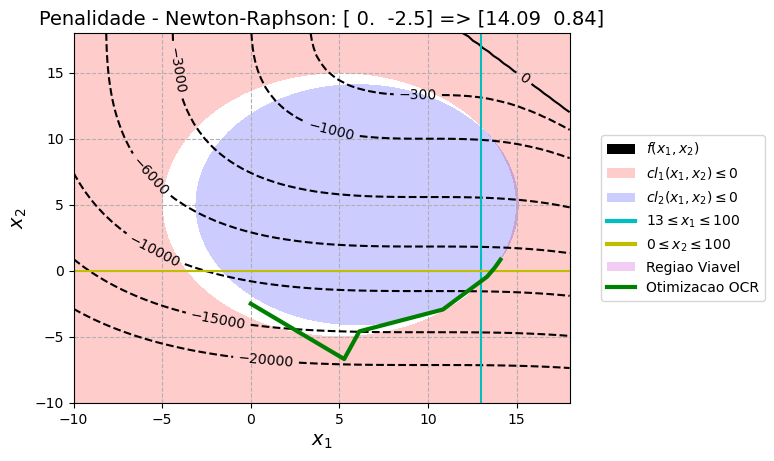

In [ ]:
x1 = np.linspace(-10,18)
x2 = np.linspace(-10,18)
X1, X2 = np.meshgrid(x1, x2)
levellist = [-20000, -15000,-10000,-6000, -3000, -1000, -300, 0]

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, levellist, colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

X3 = cl1([X1,X2])
ax.contourf(X1, X2, X3, [-100000, 0], colors='red', alpha=0.2)

X3 = cl2([X1,X2])
ax.contourf(X1, X2, X3, [-10000000, 0], colors='blue', alpha=0.2)

X3 = cl3([X1,X2])
ax.contour(X1, X2, X3, [0], colors='c')

X3 = cl5([X1,X2])
ax.contour(X1, X2, X3, [0], colors='y')
    
x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

line3, = ax.plot(x, y, color='g', linewidth='3')

proxy = [plt.Rectangle((0,0),1,1,fc = 'black'),plt.Rectangle((0,0),1,1,fc = 'r', alpha=0.2),plt.Rectangle((0,0),1,1,fc = 'b', alpha=0.2), plt.Line2D([0], [0], lw=3,  color='c'), plt.Line2D([0], [0], lw=3,  color='y'),  plt.Rectangle((0,0),1,1,fc = 'm', alpha=0.2), line3]    
ax.legend(proxy, [f'$f(x_1,x_2)$', '$cl_1(x_1,x_2) \leq 0$','$cl_2(x_1,x_2) \leq 0$', '$13 \leq x_1 \leq 100$', '$0 \leq x_2 \leq 100$', 'Regiao Viavel', 'Otimizacao OCR'], bbox_to_anchor=(1.05, 0.5), loc='center left')

ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.grid(linestyle='--')
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()